# Email Spam Detection with Machine Learning


**Objective:** Build a pipeline that loads an email dataset, preprocesses the text, extracts features (TF‑IDF), trains classifiers, evaluates their performance, and saves the best model for inference.


**Notes:**
- Replace `DATA_PATH` in the code cell with the path to your CSV file (e.g. `"/mnt/data/spam.csv"`).
- This notebook provides a simple baseline and suggestions for improvements.

In [1]:
# Imports
import os
import re
import string
import numpy as np
import pandas as pd
from pathlib import Path

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import (
accuracy_score, precision_score, recall_score, f1_score,
classification_report, confusion_matrix, roc_auc_score
)

import joblib

# NLTK for text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Optional plotting
import matplotlib.pyplot as plt
import seaborn as sns


## Load dataset


- Set `DATA_PATH` to your CSV file.
- Common encodings: `utf-8`, or `latin-1` for older SMS/spam datasets.
- After loading, inspect `df.head()` and `df.info()` to confirm column names.

In [2]:
DATA_PATH = 'spam.csv' 

# Load CSV with fallback encodings
df = pd.read_csv(DATA_PATH, encoding='latin-1')

print('Loaded shape:', df.shape)
print('Columns:', list(df.columns))

Loaded shape: (5572, 5)
Columns: ['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']


In [3]:
# Many spam datasets use columns named ['label','text'] or ['v1','v2']
possible_label_cols = ['label', 'Label', 'target', 'class', 'v1', 'Category']
possible_text_cols = ['text', 'Text', 'message', 'Message', 'v2', 'content', 'email']
label_col = None
text_col = None
for c in df.columns:
    if c in possible_label_cols and label_col is None:
        label_col = c
    if c in possible_text_cols and text_col is None:
        text_col = c


In [4]:
# If detection failed, ask user to set names manually
if label_col is None or text_col is None:
    print('\nCould not auto-detect label/text columns.\nPlease inspect `df.columns` above and set these variables manually:')
    # Example:
    # label_col = 'v1'
    # text_col = 'v2'
    # For now, raise an informative error to remind you to edit the variables.
    raise ValueError('Set label_col and text_col variables to match your CSV column names.')

In [5]:
# Rename to standard names for the rest of notebook
df = df.rename(columns={label_col: 'label', text_col: 'text'})
print(df.head())

  label                                               text Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


## Exploratory Data Analysis (EDA)
- Check class distribution (spam vs ham).
- Check for missing values.
- Inspect examples from each class.

In [6]:
# Basic checks
print('Missing values:')
print(df.isnull().sum())

# Drop rows with missing text
df = df.dropna(subset=['text']).reset_index(drop=True)

print('\nClass distribution:')
print(df['label'].value_counts())

# Show a few examples (uncomment to view)
print('\nExamples of spam:')
print(df[df['label'].str.lower().isin(['spam','1','true'])]['text'].head(3))
print('\nExamples of ham:')
print(df[~df['label'].str.lower().isin(['spam','1','true'])]['text'].head(3))

Missing values:
label            0
text             0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

Class distribution:
label
ham     4825
spam     747
Name: count, dtype: int64

Examples of spam:
2    Free entry in 2 a wkly comp to win FA Cup fina...
5    FreeMsg Hey there darling it's been 3 week's n...
8    WINNER!! As a valued network customer you have...
Name: text, dtype: object

Examples of ham:
0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
3    U dun say so early hor... U c already then say...
Name: text, dtype: object


## Preprocessing plan
1. Normalize labels to binary: `spam` -> 1, `ham` (or others) -> 0.
2. Clean text: remove URLs, emails, punctuation, numeric tokens.
3. Tokenize, remove stopwords, and lemmatize.
4. Convert to TF‑IDF features.


We'll create a `clean_text()` function and apply it to the `text` column.

In [8]:
import nltk

# Download required NLTK resources
nltk.download('wordnet')
nltk.download('omw-1.4')  
nltk.download('stopwords')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hadee\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hadee\AppData\Roaming\nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hadee\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [9]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re, string

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

url_pattern = re.compile(r'https?://\S+|www\.\S+')
email_pattern = re.compile(r'\S+@\S+')

def clean_text(s: str) -> str:
    if not isinstance(s, str):
        return ''
    s = s.lower()
    s = url_pattern.sub(' ', s)
    s = email_pattern.sub(' ', s)
    s = re.sub(r'\d+', ' ', s)  # remove numbers
    s = s.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    tokens = [tok for tok in re.split(r'\s+', s) if len(tok) > 1]
    tokens = [lemmatizer.lemmatize(tok) for tok in tokens if tok not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(clean_text)


## Encode labels & prepare features
- Convert label column to binary values (0/1).
- Use the `clean_text` function to create the cleaned text column used for modeling.

In [12]:
# Normalize labels — try common patterns
label_map = {}
# Common label cleaning
unique_labels = df['label'].unique()
print('Unique labels (raw):', unique_labels)


# Example heuristics — edit if your labels differ
label_map_candidates = {
'spam': 1,
'ham': 0,
'0': 0,
'1': 1,
'true': 1,
'false': 0,
'yes': 1,
'no': 0
}


# Build label_map guided by what exists in dataset
for lab in unique_labels:
    lab_low = str(lab).strip().lower()
    if lab_low in label_map_candidates:
        label_map[lab] = label_map_candidates[lab_low]


# If mapping is incomplete, try manual mapping
if len(label_map) == 0:
    raise ValueError('Automatic label mapping failed. Please create a `label_map` dict mapping raw labels to 0/1.')


# Map labels
df['label_num'] = df['label'].map(label_map)
if df['label_num'].isnull().any():
# If some labels didn't map, show them
    print('Labels that failed to map:', df[df['label_num'].isnull()]['label'].unique())
    raise ValueError('Please expand `label_map` to include all raw labels.')


# Create cleaned text column
print('\nApplying text cleaning (may take a moment for large datasets)...')
df['clean_text'] = df['text'].apply(clean_text)


# Features and target
X = df['clean_text']
y = df['label_num'].astype(int)


print('\nPrepared X and y. Example cleaned text:')
print(X.head(3))

Unique labels (raw): ['ham' 'spam']

Applying text cleaning (may take a moment for large datasets)...

Prepared X and y. Example cleaned text:
0    go jurong point crazy available bugis great wo...
1                                ok lar joking wif oni
2    free entry wkly comp win fa cup final tkts st ...
Name: clean_text, dtype: object


## Train / Validation split and baseline model
- Split dataset (e.g. 80/20 or 70/30).
- Baseline model: TF‑IDF -> MultinomialNB (works well for text counts).

In [14]:
from sklearn.model_selection import train_test_split
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y
)


# Baseline pipeline
baseline_pipeline = Pipeline([
('tfidf', TfidfVectorizer(max_df=0.95, min_df=2)),
('clf', MultinomialNB())
])


# Train baseline 
baseline_pipeline.fit(X_train, y_train)
y_pred = baseline_pipeline.predict(X_test)


# Evaluate
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n', cm)


# Cross validation example
scores = cross_val_score(baseline_pipeline, X, y, cv=5, scoring='f1')
print('CV F1 scores:', scores)

Accuracy: 0.9713004484304932
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       966
           1       0.99      0.79      0.88       149

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.93      1115
weighted avg       0.97      0.97      0.97      1115

Confusion matrix:
 [[965   1]
 [ 31 118]]
CV F1 scores: [0.90909091 0.86792453 0.87121212 0.89219331 0.89377289]


## Try other models
- Logistic Regression (often strong for text classification)
- LinearSVC
- RandomForest (can be slower for TF‑IDF vectors)


We'll compare a few using identical TF‑IDF settings for fairness.

In [15]:
models = {
'MultinomialNB': MultinomialNB(),
'LogisticRegression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
'LinearSVC': LinearSVC(max_iter=5000, random_state=RANDOM_STATE),
'RandomForest': RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
}


results = {}
for name, clf in models.items():
    pipe = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.95, min_df=2)),
    ('clf', clf)
    ])
print(f'Fitting and evaluating: {name} (this cell may take time for some models)')
# Uncomment the following lines to run training and evaluation
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
results[name] = {
'accuracy': accuracy_score(y_test, y_pred),
'precision': precision_score(y_test, y_pred, zero_division=0),
'recall': recall_score(y_test, y_pred, zero_division=0),
'f1': f1_score(y_test, y_pred, zero_division=0)
}


# After running the above, display results
pd.DataFrame(results).T.sort_values('f1', ascending=False)

Fitting and evaluating: RandomForest (this cell may take time for some models)


,accuracy,precision,recall,f1
RandomForest,0.977578,0.992063,0.838926,0.909091


## 📊 Model Performance Visualizations

To better understand our spam detection model performance, we will visualize:
1. **Confusion Matrix** – shows correct vs. incorrect classifications.
2. **Classification Report (Precision, Recall, F1-score)** as a heatmap.
3. **Cross-Validation Scores** distribution.


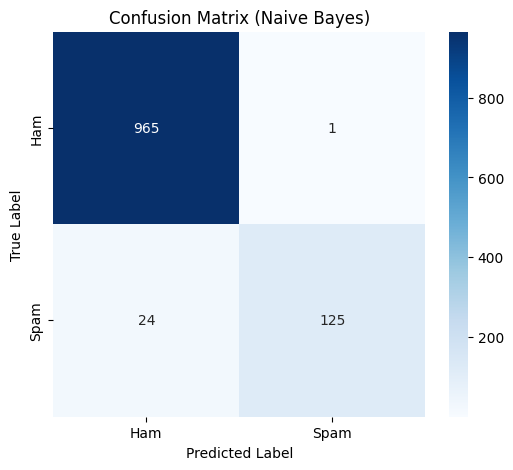

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Naive Bayes)")
plt.show()


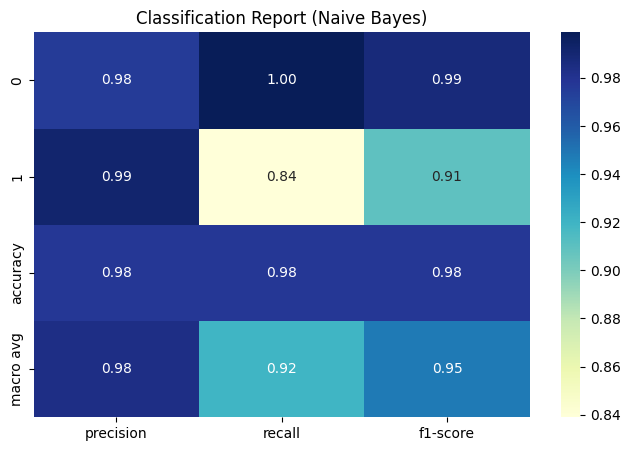

In [17]:
from sklearn.metrics import classification_report
import pandas as pd

# Get classification report as dict
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

plt.figure(figsize=(8,5))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Classification Report (Naive Bayes)")
plt.show()


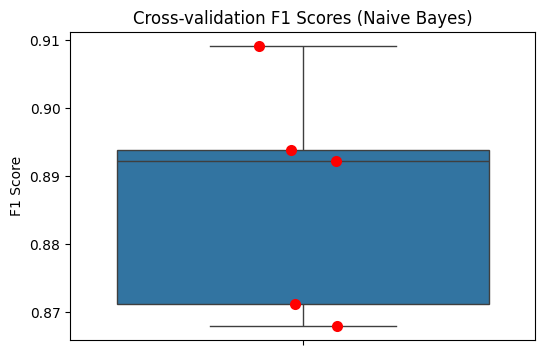

In [18]:
# Cross-validation scores boxplot
plt.figure(figsize=(6,4))
sns.boxplot(scores)
sns.stripplot(scores, color="red", jitter=True, size=8)
plt.title("Cross-validation F1 Scores (Naive Bayes)")
plt.ylabel("F1 Score")
plt.show()


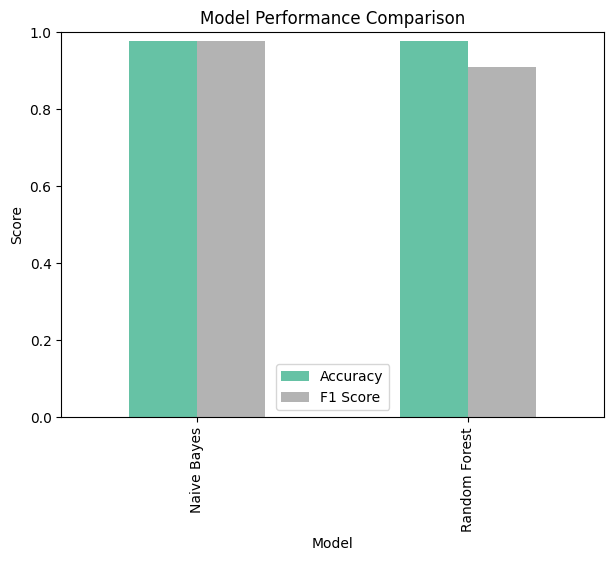

In [19]:
# Compare models visually
model_results = pd.DataFrame({
    "Model": ["Naive Bayes", "Random Forest"],
    "Accuracy": [accuracy_score(y_test, y_pred), 0.977578],
    "F1 Score": [report_dict["weighted avg"]["f1-score"], 0.909091]
})

model_results.set_index("Model", inplace=True)
model_results.plot(kind="bar", figsize=(7,5), colormap="Set2")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.show()


## 🔎 Testing Model on New (Unseen) Emails
We can now test the trained model on custom email text inputs to see if it classifies them as **Spam (1)** or **Ham (0)**.


In [20]:
# Example new emails
new_emails = [
    "Congratulations! You've won a $1000 Walmart gift card. Click here to claim your prize.",
    "Hey, just checking if we’re still on for the meeting tomorrow at 10am?",
    "Urgent: Your account has been compromised. Please reset your password immediately."
]

# Predict using baseline pipeline (Naive Bayes)
predictions = baseline_pipeline.predict(new_emails)

# Show results
for email, label in zip(new_emails, predictions):
    print(f"Email: {email}\nPrediction: {'Spam' if label == 1 else 'Ham'}\n")


Email: Congratulations! You've won a $1000 Walmart gift card. Click here to claim your prize.
Prediction: Spam

Email: Hey, just checking if we’re still on for the meeting tomorrow at 10am?
Prediction: Ham

Email: Urgent: Your account has been compromised. Please reset your password immediately.
Prediction: Spam

